# Image Denoising with Autoencoders

## Introduction and Importing Libraries


In [1]:
import numpy as np

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

%matplotlib inline

## Data Preprocessing


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float')/255.
x_test = x_test.astype('float')/255.

x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))

## Adding Noise


In [3]:
x_train_noisy = x_train + np.random.rand(60000, 784) * 0.9
x_test_noisy = x_test + np.random.rand(10000, 784) * 0.9

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

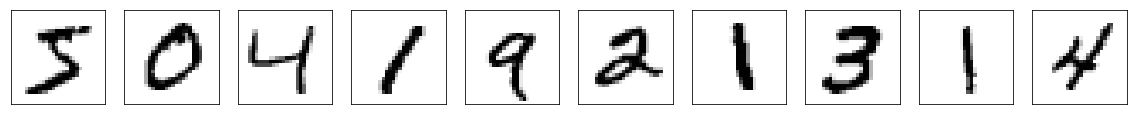

In [4]:
def plot(x, p, labels = False):
    plt.figure(figsize=(20,2))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i].reshape(28,28), cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if labels:
            plt.xlabel(np.argmax(p[i]))
    plt.show()
    return
plot(x_train, None)

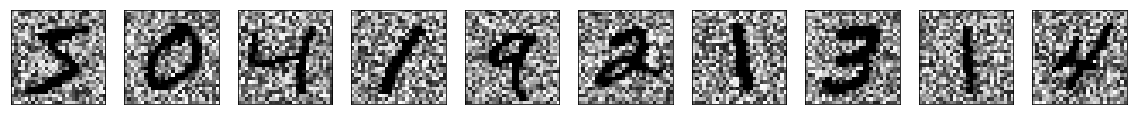

In [5]:
plot(x_train_noisy, None)

## Building and Training a Classifier


In [6]:
classifier = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

classifier.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.fit(x_train, y_train, epochs=3, batch_size=512)

Epoch 1/3
60000/60000 [==============================] - 5s 80us/step - loss: 0.4198 - acc: 0.8870
Epoch 2/3
60000/60000 [==============================] - 4s 70us/step - loss: 0.1505 - acc: 0.9565
Epoch 3/3
60000/60000 [==============================] - 4s 68us/step - loss: 0.1018 - acc: 0.9708


In [7]:
loss, acc = classifier.evaluate(x_test, y_test)
print(acc)

10000/10000 [==============================] - 1s 64us/step
0.9702


In [8]:
loss, acc = classifier.evaluate(x_test_noisy, y_test)
print(acc)

10000/10000 [==============================] - 0s 46us/step
0.1632


## Building the Autoencoder


In [9]:
input_image = Input(shape=(784,))
encoded = Dense(64, activation='relu')(input_image)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_image, decoded)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

##  Training the Autoencoder


In [10]:
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=100, batch_size=512,
    validation_split=0.2, verbose=False,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        LambdaCallback(on_epoch_end=lambda e,l: print('{:.3f}'.format(l['val_loss']), end=' _ '))
    ]
)

print(' _ ')
print('Training is complete!')

0.253 _ 0.220 _ 0.190 _ 0.174 _ 0.163 _ 0.154 _ 0.147 _ 0.142 _ 0.137 _ 0.133 _ 0.130 _ 0.127 _ 0.124 _ 0.122 _ 0.120 _ 0.118 _ 0.117 _ 0.115 _ 0.114 _ 0.113 _ 0.112 _ 0.111 _ 0.110 _ 0.109 _ 0.109 _ 0.108 _ 0.108 _ 0.107 _ 0.107 _ 0.106 _ 0.106 _ 0.106 _ 0.105 _ 0.105 _ 0.105 _ 0.104 _ 0.105 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.102 _ 0.103 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _  _ 
Training is complete!


## Denoised Images


In [11]:
predictions = autoencoder.predict(x_test_noisy)

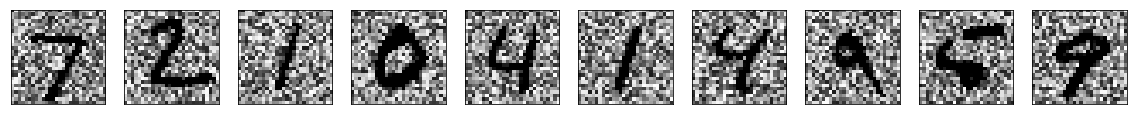

In [12]:
plot(x_test_noisy,None)

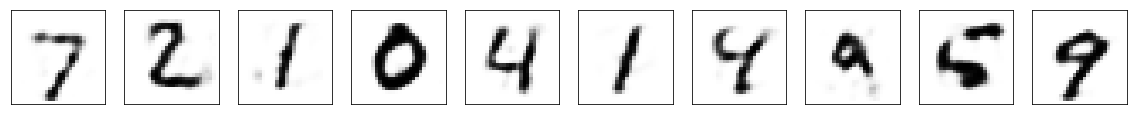

In [13]:
plot(predictions,None)

In [14]:
loss , acc = classifier.evaluate(predictions, y_test)
print(acc)

10000/10000 [==============================] - 1s 65us/step
0.9502


## Composite Model


In [15]:
input_image = Input(shape=(784,))
x = autoencoder(input_image)
y = classifier(x)

denoise_and_classify = Model(input_image,y )

In [17]:
predictions = denoise_and_classify.predict(x_test_noisy)

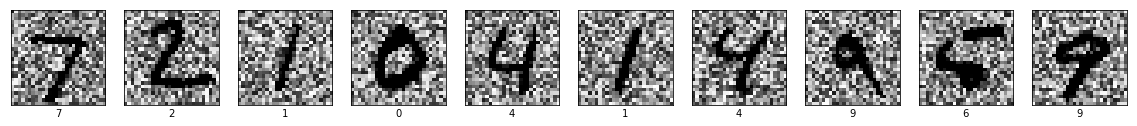

In [18]:
plot(x_test_noisy, predictions, True)

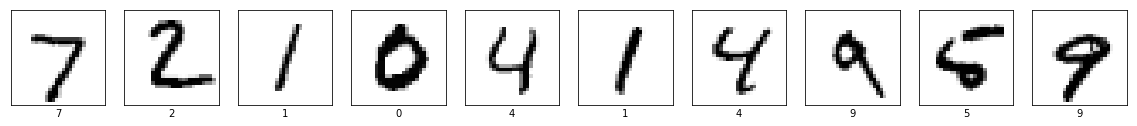

In [19]:
plot(x_test, to_categorical(y_test), True)